In [1]:
# Custom functionalities
import visionNew
from Utilities.metrics import pixelwiseAccuracy
from Utilities.datasetHandler import CityscapesDataset
from Utilities.modelHandler import modelFCN

import torch
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torch import nn
from torchvision.models import ResNet50_Weights
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchvision.utils import draw_segmentation_masks

device = torch.device('cpu')
if torch.cuda.is_available(): device = torch.device('cuda')

torch.cuda.empty_cache()

In [2]:
### DATASET ###
img_directory = '/mnt/data/course/psarin/inm705/leftImg8bit'
ground_truth_directory = '/mnt/data/course/psarin/inm705/gtFine_trainvaltest/gtFine'
n_classes = 34

# Import datasets
dt_train = CityscapesDataset(image_directory = img_directory,
                            gt_directory = ground_truth_directory,
                            phase = 'train',
                            num_classes = n_classes)

dt_val = CityscapesDataset(image_directory = img_directory,
                            gt_directory = ground_truth_directory,
                            phase = 'val',
                            num_classes = n_classes)

dt_test = CityscapesDataset(image_directory = img_directory,
                            gt_directory = ground_truth_directory,
                            phase = 'test',
                            num_classes = n_classes)

# Initialise dataloaders
dataloader_args = {'batch_size':20, 'shuffle':False}

## TRAIN dataset
trainloader = DataLoader(dt_train, **dataloader_args)
## VAL dataset
valloader = DataLoader(dt_val, **dataloader_args)
## TEST dataset
testloader = DataLoader(dt_test, batch_size=10)


# Pascal VOC categories
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                      'cow', 'diningtable', 'dog', 'horse',
                      'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

# convert list to dict
pascal_voc_classes = {}
for id, name in enumerate(object_categories): 
    pascal_voc_classes[name]=id # these are the same indices used to create the label vector y in the dataset 
    

In [3]:
## MODEL Pretrained with RESNET 50
# Initialize model with the best available weights
FCN_weights = FCN_ResNet50_Weights.DEFAULT
backbone_weights = ResNet50_Weights.DEFAULT
model = fcn_resnet50(backbone_weights=backbone_weights).to(device)

model.backbone.requires_grad_(False)
model.classifier[4] = nn.Conv2d(512, n_classes, kernel_size=(1, 1), stride=(1, 1))
model.classifier.requires_grad_(True)

cel = CrossEntropyLoss()
ad = Adam(model.parameters())

fcn1 = modelFCN(model, loss_function=cel, optimizer = ad )
fcn1.model.to(device);

In [6]:
L = fcn1.train_model(trainloader, total_epochs=20)

Completed epoch 1


KeyboardInterrupt: 

In [5]:
# Load checkpoint
fcn1.model.load_state_dict(torch.load("Checkpoints/test_epoch_3.pth"))
fcn1.model.eval();

In [6]:
# Step 4: Use the model and visualize the prediction
fcn1.model.eval()
_, X_test, y_test = next(iter(testloader))
X_test, y_test = X_test.to(device), y_test.to(device) 

fcn1.model.to(device)
pred = fcn1.model(X_test)['out']

# Apply sigmoid and threshold value
out = torch.sigmoid(pred) > 0.5
out = out.int()

# Computing metrics
pixelwiseAccuracy(out,y_test)

0.9993874430656433

## Visualisation

In [54]:
X_viz, X_viz_norm = dt_test.get_image_visualization(1)

# Process the input inside with the model
pred_viz = fcn1.model(X_viz_norm.unsqueeze(0).to(device))['out']

out_viz = torch.sigmoid(pred_viz) > 0.5
out_viz = out_viz.int()[0] # unpack the batch with [0]

# Create the mask with argmax
mask = out_viz.argmax(dim=0)

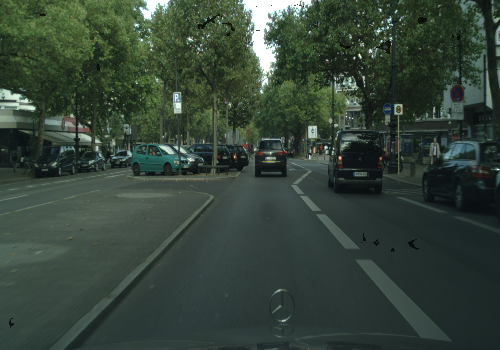

In [56]:
# Single class visualisation
class_id = 9
single_class_mask = (mask == class_id)

sm = draw_segmentation_masks(X_viz, masks=single_class_mask, alpha=0.7)
to_pil_image(sm)

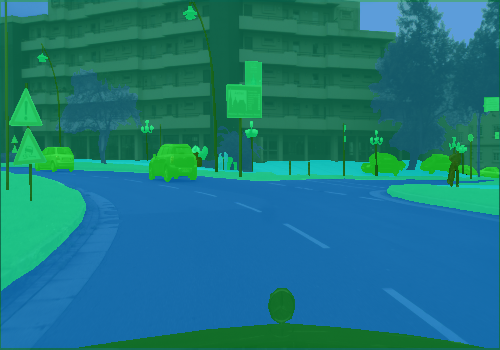

In [5]:
# Multiple class visualisation
bool_masks = mask.cpu() == torch.arange(n_classes)[:, None, None]

sm = draw_segmentation_masks(X_viz, masks=bool_masks, alpha=0.7)
to_pil_image(sm)

## Check the model

In [12]:
from Utilities.torchsummaryNew import summary

In [13]:
device = torch.device('cuda')

In [14]:
x = torch.randn(1, 3, 224, 224).to(device)
fcn1.model.to(device);

In [15]:
summary(fcn1.model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

(tensor(32961630), tensor(9453598))

## Labels

In [ ]:
from Utilities.cityscapesLables import CityscapesLabels

labels = CityscapesLabels.get_labels()

labels()

In [7]:
from collections import namedtuple

Label = namedtuple( 'Label' , [
            'name'        , 
            'id'          , # An integer ID that is associated with this label. The IDs are used to represent the label in ground truth images
            'trainId'     , 
            'ignoreInEval', # Whether pixels having this class as ground truth label are ignored during evaluations or not
            'color'       , # The color of this label
            ] )

#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
            #       name                     id    trainId   ignoreInEval   color
            Label(  'unlabeled'            ,  0 ,      255 ,  True         , (  0,  0,  0) ),
            Label(  'ego vehicle'          ,  1 ,      255 ,  True         , (  0,  0,  0) ),
            Label(  'rectification border' ,  2 ,      255 ,  True         , (  0,  0,  0) ),
            Label(  'out of roi'           ,  3 ,      255 ,  True         , (  0,  0,  0) ),
            Label(  'static'               ,  4 ,      255 ,  True         , (  0,  0,  0) ),
            Label(  'dynamic'              ,  5 ,      255 ,  True         , (111, 74,  0) ),
            Label(  'ground'               ,  6 ,      255 ,  True         , ( 81,  0, 81) ),
            Label(  'road'                 ,  7 ,        0 ,  False        , (128, 64,128) ),
            Label(  'sidewalk'             ,  8 ,        1 ,  False        , (244, 35,232) ),
            Label(  'parking'              ,  9 ,      255 ,  True         , (250,170,160) ),
            Label(  'rail track'           , 10 ,      255 ,  True         , (230,150,140) ),
            Label(  'building'             , 11 ,        2 ,  False        , ( 70, 70, 70) ),
            Label(  'wall'                 , 12 ,        3 ,  False        , (102,102,156) ),
            Label(  'fence'                , 13 ,        4 ,  False        , (190,153,153) ),
            Label(  'guard rail'           , 14 ,      255 ,  True         , (180,165,180) ),
            Label(  'bridge'               , 15 ,      255 ,  True         , (150,100,100) ),
            Label(  'tunnel'               , 16 ,      255 ,  True         , (150,120, 90) ),
            Label(  'pole'                 , 17 ,        5 ,  False        , (153,153,153) ),
            Label(  'polegroup'            , 18 ,      255 ,  True         , (153,153,153) ),
            Label(  'traffic light'        , 19 ,        6 ,  False        , (250,170, 30) ),
            Label(  'traffic sign'         , 20 ,        7 ,  False        , (220,220,  0) ),
            Label(  'vegetation'           , 21 ,        8 ,  False        , (107,142, 35) ),
            Label(  'terrain'              , 22 ,        9 ,  False        , (152,251,152) ),
            Label(  'sky'                  , 23 ,       10 ,  False        , ( 70,130,180) ),
            Label(  'person'               , 24 ,       11 ,  False        , (220, 20, 60) ),
            Label(  'rider'                , 25 ,       12 ,  False        , (255,  0,  0) ),
            Label(  'car'                  , 26 ,       13 ,  False        , (  0,  0,142) ),
            Label(  'truck'                , 27 ,       14 ,  False        , (  0,  0, 70) ),
            Label(  'bus'                  , 28 ,       15 ,  False        , (  0, 60,100) ),
            Label(  'caravan'              , 29 ,      255 ,  True         , (  0,  0, 90) ),
            Label(  'trailer'              , 30 ,      255 ,  True         , (  0,  0,110) ),
            Label(  'train'                , 31 ,       16 ,  False        , (  0, 80,100) ),
            Label(  'motorcycle'           , 32 ,       17 ,  False        , (  0,  0,230) ),
            Label(  'bicycle'              , 33 ,       18 ,  False        , (119, 11, 32) ),
            Label(  'license plate'        , -1 ,       -1 ,  True         , (  0,  0,142) ),
        ]

#--------------------------------------------------------------------------------
# Create dictionaries for a fast lookup
#--------------------------------------------------------------------------------

# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]

In [17]:
name2label.get("car").color

(0, 0, 142)